In [1]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
# import sympy as sym
# from sympy import S,N
# import locale
# from sklearn.linear_model import LinearRegression
from keras.utils import np_utils #one hot encoding
from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation
from keras.layers import Flatten # 將資料展平
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta
from keras.models import model_from_json
from keras.datasets import mnist # mnist內 包含手寫測試資料

# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Dropout

import matplotlib.image as mpimg #import image file
from sklearn.model_selection import train_test_split

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28
x_train.max =  1.0 
x_train.min =  0.0 
y_test[0] =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


y_test_even_odd統計:


(array([4926.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5074.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

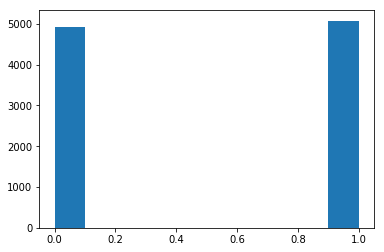

In [2]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)
# y_test0.shape

x_train = x_train0.reshape(x_train0.shape[0], -1)
x_test = x_test0.reshape(x_test0.shape[0], -1)
x_train -= x_train.min()
x_train = x_train/x_train.max()
y_train = np_utils.to_categorical(y_train0, 10)
y_test = np_utils.to_categorical(y_test0, 10)

print("x_train.max = ", x_train.max(), "\nx_train.min = ", x_train.min(), "\ny_test[0] = ", y_test[0])

y_train_even_odd = np.ones_like(y_train0)
y_train_even_odd[y_train0%2==0] = 0

y_test_even_odd = np.ones_like(y_test0) # return 全部都是1的矩陣，shape跟y_test一樣
y_test_even_odd[y_test0%2==0] = 0

print("\n\ny_test_even_odd統計:")
plt.hist(y_test_even_odd)

In [3]:
def plotNumber(idx):
    plt.imshow(x_train0[idx], 'Greys')
    plt.title("Number: %d\n Evev/odd label: %d" %(y_train0[idx], y_train_even_odd[idx]))
    plt.axis('off')
interact(plotNumber, idx=IntSlider(value=0, description='Data Index', min=0, max=x_train0.shape[0]-1))

interactive(children=(IntSlider(value=0, description='Data Index', max=59999), Output()), _dom_classes=('widge…

<function __main__.plotNumber(idx)>

In [4]:
first_layer = [Dense(500, input_dim=784), Activation('relu')]
second_layer = [Dense(250), Activation('relu')]
third_layer = [Dense(80), Activation('relu')]
fourth_layer = [Dense(10), Activation('softmax')]

model = Sequential(first_layer + second_layer + third_layer + fourth_layer)
# 這種方法可以複製某幾層是從別的已經訓練好的model來的
# 就是「轉移學習」！

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20080     
_________________________________________________________________
activation_3 (Activation)    (None, 80)                0         
_________________________________________________________________
dens

In [5]:
model.compile(loss='mse', optimizer=SGD(lr=0.087), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=100, epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
60000/60000 [==============================] - 7s 111us/step - loss: 0.0742 - acc: 0.4931
Epoch 2/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.0341 - acc: 0.8081
Epoch 3/30
60000/60000 [==============================] - 6s 105us/step - loss: 0.0205 - acc: 0.8826
Epoch 4/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0165 - acc: 0.9006
Epoch 5/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0146 - acc: 0.9099
Epoch 6/30
60000/60000 [==============================] - 6s 105us/step - loss: 0.0134 - acc: 0.9167
Epoch 7/30
60000/60000 [==============================] - 6s 101us/step - loss: 0.0125 - acc: 0.9213
Epoch 8/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.0118 - acc: 0.9261
Epoch 9/30
60000/60000 [==============================] - 6s 101us/step - loss: 0.0112 - acc: 0.9294
Epoch 10/30
60000/60000 [==================

In [6]:
score = model.evaluate(x_test, y_test)
print('loss:', score[0])
print('正確率', score[1])

10000/10000 [==============================] - 1s 68us/step
loss: 0.008193092489594302
正確率 0.9589


# 開始轉移學習

我們要來用上面這個已經學習好的model來做新的even_odd_model


In [9]:
even_odd_fourth_layer = [Dense(2), Activation('softmax')]

# 可以讓我們不訓練這幾層!!
first_layer[0].trainable = False
second_layer[0].trainable = False
third_layer[0].trainable = False

even_odd_model = Sequential(first_layer + second_layer + third_layer + even_odd_fourth_layer)
even_odd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20080     
_________________________________________________________________
activation_3 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 162       
__________

## 可以看到

Total params: 537,992

Trainable params: 162 <-------------需要訓練的params非常少

Non-trainable params: 537,830

In [11]:
even_odd_model.compile(loss='mse', optimizer=SGD(lr=0.087), metrics=['accuracy'])
even_odd_model.fit(x_train, np_utils.to_categorical(y_train_even_odd, 2), batch_size=100, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.0703 - acc: 0.9069
Epoch 2/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0525 - acc: 0.9327
Epoch 3/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0482 - acc: 0.9380
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0454 - acc: 0.9421
Epoch 5/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0435 - acc: 0.9447
Epoch 6/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0422 - acc: 0.9465
Epoch 7/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0413 - acc: 0.9475
Epoch 8/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0403 - acc: 0.9488
Epoch 9/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0396 - acc: 0.9502
Epoch 10/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0392 - acc: 0.9498

In [12]:
even_odd_score = even_odd_model.evaluate(x_test, np_utils.to_categorical(y_test_even_odd, 2))
print('loss:', even_odd_score[0])
print('正確率', even_odd_score[1])

10000/10000 [==============================] - 1s 69us/step
loss: 0.04797879063578556
正確率 0.9518


# 轉移學習成功

## 資源

雖然這個模型看起來很隨便，但轉移學習的模型**差不多**都是這樣建立的，實際上， Keras 亦提供許多被證實有良好表現且訓練好 (pre-trained) 的模型，如:

* Xception
* VGG16
* VGG19   (VGG為早期物件辨識的模型，但太胖)
* ResNet50    (ResNet50還不錯，但也有點胖)
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet

詳細的使用方式可參考 Keras Documentation: https://keras.io/applications/
(有範例告訴我們怎麼讀去權重、拆layers等)

但使用這些模型進行轉移學習，**可能**需要 ``Sequential`` 以外寫法，以及更多神經網路的建構技巧。